# MOM6 ANALYSIS - East Tas

This notebook will be the first look at the heat budget terms that I saved online. The purpose of this will eventually be to understand the cross-shore fluxes that lead to heat within the coastal domain. 

This will ultimately just follow the example in the MOM6 Analysis cookbook

In [1]:
# standard libraries

import xarray as xr
import numpy as np
import glob

# plotting libraries
import matplotlib.pyplot as plt
from matplotlib import patches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.lines as mlines
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import cmocean as cmo
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# dask libraries
from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')

In [2]:
import xesmf
from xgcm import Grid

In [2]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46113,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:35995,Total threads: 1
Dashboard: /proxy/43817/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:42729,


In [3]:
client.close()

In [4]:
# set paths to model output
## SRM
eac_003 = '/scratch/v45/jr5971/mom6-setonix/eac_iaf_003/'
## LRM
sthpac_01 = '/scratch/v45/jr5971/mom6-setonix/sthpac_iaf_01/'
## PARENT
access = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/'
# Subsetted head directory
subset_head = '/scratch/v45/jr5971/mom6-setonix/subsetted_data/'
speed_head = subset_head + 'u-v-speed/'
zarr_head = subset_head + 'zarr-files/'

In [5]:
# import os
# os.chdir('/home/581/jr5971/jr5971/notebooks/')
# # from custom_funcs import *
# from myfuncs import *

## Contents

## 1. Bathymetry

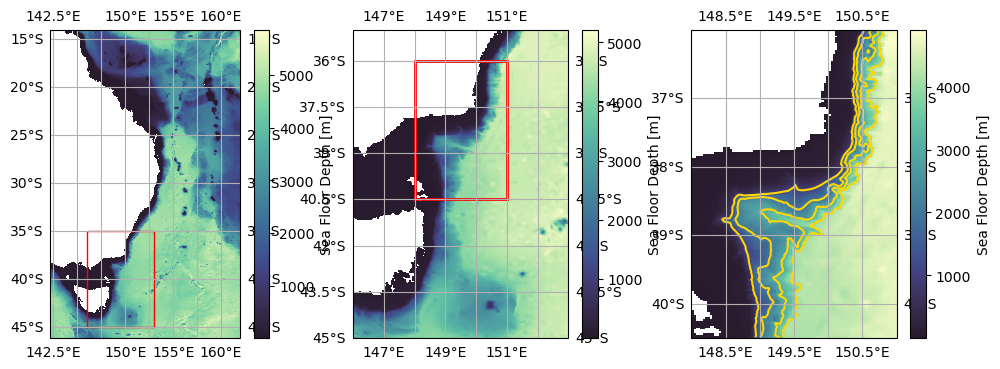

In [24]:
eac_bath = xr.open_dataset(eac_003 + 'output000/19900202.ocean_static.nc')['deptho']
eac_idx = {'W':eac_bath.xh.min().values+360, 'E':eac_bath.xh.max().values+360,
           'S':eac_bath.yh.min().values, 'N':eac_bath.yh.max().values}
gebco_bath = xr.open_dataset("/g/data/ik11/inputs/GEBCO_2022/GEBCO_2022.nc")['elevation'].sel(
    lat=slice(eac_idx['S'], eac_idx['N']), lon=slice(eac_idx['W'], eac_idx['E']))

# set boundary for east-tas
# boat_idx = {'W':150, 'E':158, 'S':-35, 'N':-24}
idx_etas = {'W':146, 'E':153, 'S':-45, 'N':-35} # EAST TAS
etas_box = patches.Rectangle((idx_etas['W'], idx_etas['S']), (idx_etas['E']-idx_etas['W']),
                             (idx_etas['N']-idx_etas['S']), fill=None,color='r', transform=ccrs.PlateCarree())
# Let's just plot the EAC bathymetry so we can identify the domain of interest
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4),  subplot_kw={'projection':ccrs.PlateCarree()})
eac_bath.plot(ax=ax1, cmap=cmo.cm.deep_r, transform=ccrs.PlateCarree());
ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
ax1.add_patch(etas_box)
eac_bath.sel(xh=slice(idx_etas['W']-360, idx_etas['E']-360), yh=slice(idx_etas['S'], idx_etas['N'])).plot(
    ax=ax2, cmap=cmo.cm.deep_r, transform=ccrs.PlateCarree())
ax2.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
# zoom in no northern slope section;
idx_vicSlope = {'W':148, 'E':151, 'S':-40.5, 'N':-36}
vicSlope_box = patches.Rectangle((idx_vicSlope['W'], idx_vicSlope['S']), (idx_vicSlope['E']-idx_vicSlope['W']), 
                                 (idx_vicSlope['N']-idx_vicSlope['S']), fill=None, color='r', linewidth=2, transform=ccrs.PlateCarree())
ax2.add_patch(vicSlope_box)
bath_vicslope = eac_bath.sel(xh=slice(idx_vicSlope['W']-360, idx_vicSlope['E']-360), yh=slice(idx_vicSlope['S'], idx_vicSlope['N']))
eac_bath.sel(xh=slice(idx_vicSlope['W']-360, idx_vicSlope['E']-360), yh=slice(idx_vicSlope['S'], idx_vicSlope['N'])).plot(
    ax=ax3, cmap=cmo.cm.deep_r, transform=ccrs.PlateCarree())
ax3.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
bath_vicslope.plot.contour(ax=ax3, levels=[1000, 2000, 3000, 4000], colors='gold')

Okay, so the above is a good way of understanding the shape of the continental slope in the EAST-TAS domain. The key feature would have to be the canyon between 38 and 39 S. This is most prominent in the 3000 m isobath where it is an extremely narrow bathymetric change. Apart from that, it doesn't look like there's anything else to significant upstream. 

**Let's now shift the longitude axis from the model reference grid to the "real" reference grid**

In [25]:
eac_bath = eac_bath.rename({'xh':'lon', 'yh':'lat'})
eac_bath['lon'] = eac_bath['lon'] + 360
# and subsets
# ETAS
bath_etas = eac_bath.sel(lon=slice(idx_etas['W'], idx_etas['E']), lat=slice(idx_etas['S'], idx_etas['N']))
bath_vicslope = eac_bath.sel(lon=slice(idx_vicSlope['W'], idx_vicSlope['E']), lat=slice(idx_vicSlope['S'], idx_vicSlope['N']))
eac_bath

<xarray.DataArray 'deptho' (lat: 1140, lon: 594)>
[677160 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -46.18 -46.16 -46.13 -46.11 ... -14.14 -14.11 -14.07
  * lon      (lon) float64 142.2 142.3 142.3 142.3 ... 161.9 161.9 162.0 162.0
Attributes:
    units:          m
    long_name:      Sea Floor Depth
    cell_methods:   area:mean yh:mean xh:mean time: point
    cell_measures:  area: areacello
    standard_name:  sea_floor_depth_below_geoid

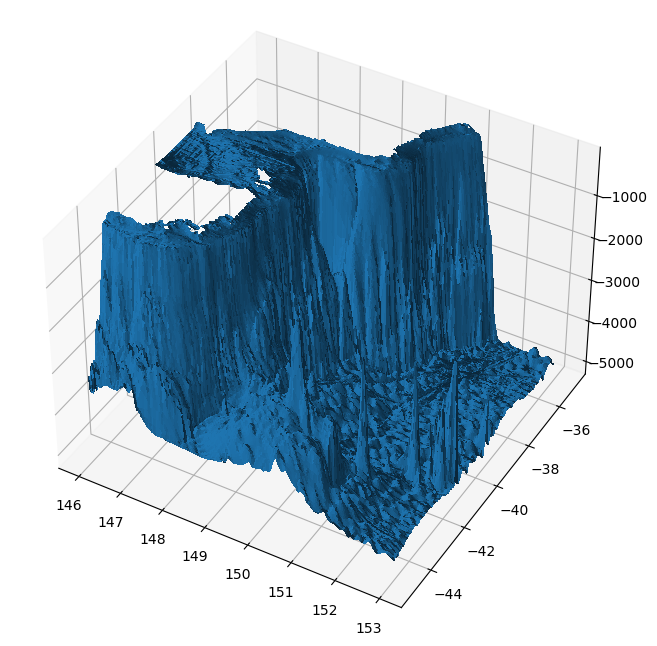

In [26]:
# EAC-003 BATHYMETRY 3D
bath = bath_etas
X, Y = np.meshgrid(bath['lon'], bath['lat'])
Z = bath.values*-1
Z_nonans = np.nan_to_num(Z, nan=0)
import cmocean as cmo


# fig, axes = plt.subplots(ncols=3, nrows=3, figsize = (18,18), subplot_kw={'projection':'3d'})
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection':'3d'})

surf = ax.plot_surface(X,Y,Z, rstride = 1, cstride = 1, linewidth=0, antialiased=False, shade=True)

# cont = ax.contour3D(X,Y,Z, 30, edgecolor='k')
ax.view_init(elev=40,azim=-60)



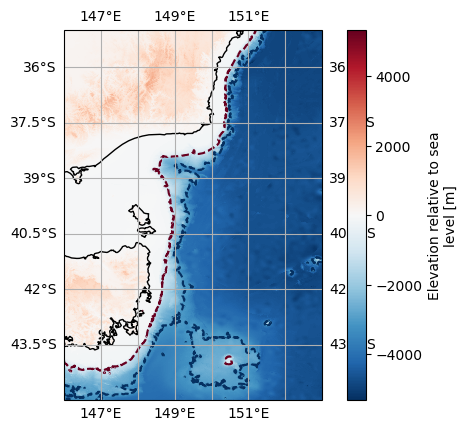

In [27]:
# GEBCO BATHYMETRY 3D
gebco_etas = gebco_bath.sel(lon=slice(idx_etas['W'], idx_etas['E']), lat=slice(idx_etas['S'], idx_etas['N']))
fig, ax= plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
gebco_etas.plot(ax=ax)
gebco_etas.plot.contour(ax=ax, levels=[-1000, -3000])
ax.coastlines()
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
# X, Y = np.meshgrid(gebco_canyon['lon'], gebco_canyon['lat'])
# Z = gebco_canyon.values
# import cmocean as cmo


# fig, ax = plt.subplots(figsize = (8,8), subplot_kw={'projection':'3d'})

# ls = LightSource(160, 45)
# rgb = ls.shade(Z, cmap=cmo.cm.topo, vmin=-5000, vmax=5000, vert_exag = 0.1, blend_mode = 'soft')

# surf = ax.plot_surface(X,Y,Z, rstride = 1, cstride = 1, facecolors=rgb, linewidth=0, antialiased=False, shade=False)
# # surf = ax.plot_surface(X,Y,Z, cmap='viridis')

# # cont = ax.contour3D(X,Y,Z, 30, edgecolor='k')
# ax.view_init(elev=90,azim=-30)

In [28]:
# load in a single 3D 'v' file
v = xr.open_dataset(eac_003 + 'output200/20060901.ocean_daily_v_3d.nc')['vo']
v = v.rename({'xh':'lon', 'yq':'lat'})
v['lon'] = v['lon'] + 360

In [29]:
v_etas = v.sel(lon=slice(idx_etas['W'], idx_etas['E']), 
                 lat=slice(idx_etas['S'], idx_etas['N'])).isel(time=0)
v_etas

<xarray.DataArray 'vo' (z_l: 100, lat: 392, lon: 210)>
[8232000 values with dtype=float32]
Coordinates:
  * z_l      (z_l) float64 0.2928 0.8999 1.552 ... 4.946e+03 5.134e+03 5.324e+03
    time     object 2006-09-01 12:00:00
  * lat      (lat) float64 -44.98 -44.95 -44.93 -44.91 ... -35.08 -35.05 -35.02
  * lon      (lon) float64 146.0 146.1 146.1 146.1 ... 152.9 152.9 153.0 153.0
Attributes:
    units:          m s-1
    long_name:      Sea Water Y Velocity
    cell_methods:   z_l:mean yq:point xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_y_velocity
    interp_method:  none

In [30]:
geb_etas = gebco_bath.sel(lon=slice(idx_etas['W'], idx_etas['E']),
                            lat=slice(idx_etas['S'], idx_etas['N']))
X_geb, Y_geb = np.meshgrid(geb_etas['lon'], geb_etas['lat'])
print(X_geb.shape, geb_etas['lon'].shape)
geb_etas_nowater = geb_etas.where(geb_etas >=0, np.nan)
geb_etas_noland = geb_etas.where(geb_etas <=0, np.nan)

(2400, 1680) (1680,)


In [31]:
z = v_etas['z_l']
x = v_etas['lon']
y = v_etas['lat']
print(x.shape, y.shape, z.shape)

(210,) (392,) (100,)


In [32]:
X, Y, Z = np.meshgrid(x, y, -z)
X = X.transpose((1,0,2))
Y = Y.transpose((1,0,2))
Z = Z.transpose((1,0,2))
print(X.shape)

(210, 392, 100)


In [33]:
data = v_etas.data.T
data_nonans = np.nan_to_num(data, nan=0)
data_nonans.shape

(210, 392, 100)

In [34]:
X_2d, Y_2d = np.meshgrid(x, y)
# X_2d = X_2d.T
# Y_2d = Y_2d.T
print(X_2d.shape)

(392, 210)


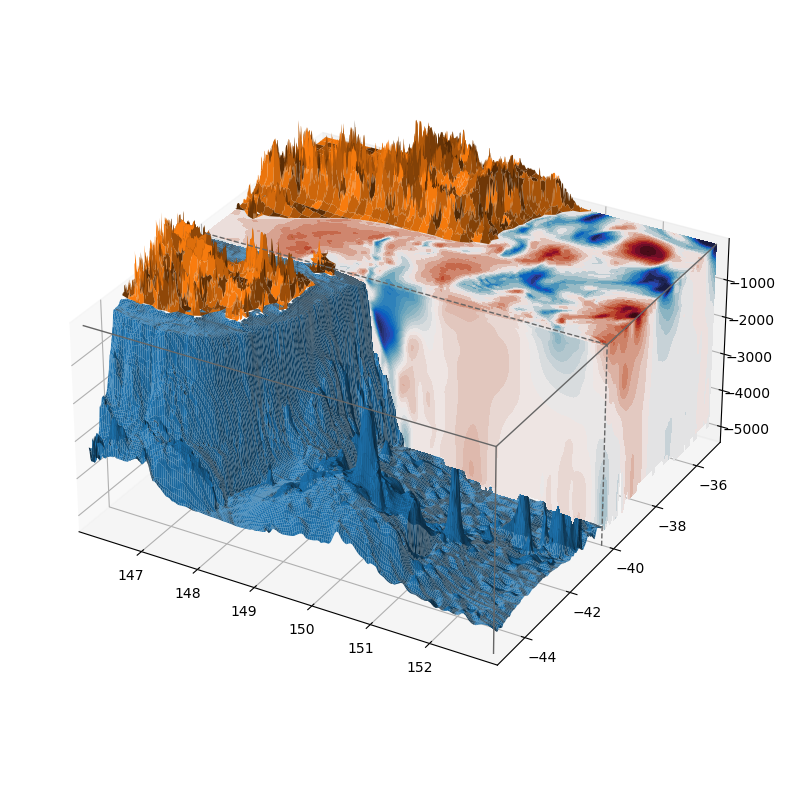

In [35]:
kw = {'cmap':cmo.cm.balance, 'vmin':-0.5, 'vmax':0.5, 
      'levels':30, 'zorder':2}

ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d', computed_zorder=False)
# plot a depth slice over constant latitude
lat_idx = len(y)//2
# lat_idx = 100
lat = y[lat_idx].values
vmin=-0.8; vmax=vmin*-1

i=2
bath2 = ax.plot_surface(X_2d[:lat_idx+i,:], Y_2d[:lat_idx+i,:], bath_etas.values[:lat_idx+i,:]*-1,
                       rstride=1, cstride=1, zorder=1)
lat_geb = 180

land = ax.plot_surface(X_geb, Y_geb, geb_etas_nowater.values, zorder=5)

# constant y
Cy = ax.contourf(X[:,lat_idx, :], data[:,lat_idx,:], Z[:,lat_idx,:],
                 zs=lat_idx, zdir='y', offset=lat, **kw)
# # constant x - last face (-1)
Cx = ax.contourf(data[-1,lat_idx: :], Y[-1,lat_idx:,:], Z[-1,lat_idx:,:], **kw,
                 zdir='x', offset=X.max())
# constnat z - top surface
Cz = ax.contourf(X[:, lat_idx:, 0], Y[:,lat_idx:,0], data[:,lat_idx:,0], **kw,
                 zdir='z', offset=0)

# Set limits of the plot from coord limits
xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
zmin, zmax = Z.min(), Z.max()
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

# Plot edges
edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
ax.plot([xmax, xmax], [lat, lat], [zmin, zmax],linestyle='--', **edges_kw)
ax.plot([xmin, xmax], [lat, lat], [zmax, zmax], linestyle='--', **edges_kw)

ax.view_init(elev=30, azim=-60, roll=0)

ax.set_box_aspect((2,2,1), zoom=0.9)

Okey dokes, so we've setup this 3D space again. Now it's time to actually start doing some quantitative work. There's a couple of things I'd like to do. 
* MHW analysis - full depth?
    - justification for full-depth:
* What can I do whilst waiting for results from the MHW analysis and also the HB stuff? Try to extract a contour and smooth it out? 

# 2. Spatial Fields

## Velocities

In [4]:
# open velocities
uv = xr.open_zarr(zarr_head + 'eac-etas-uv-z25plus.zarr', consolidated = True)
uv

0.3.0


<xarray.Dataset>
Dimensions:  (time: 9099, z_l: 12, yh: 393, xq: 210, yq: 392, xh: 210)
Coordinates:
  * time     (time) object 1990-02-02 12:00:00 ... 2014-12-31 12:00:00
  * xh       (xh) float64 -214.0 -213.9 -213.9 -213.9 ... -207.1 -207.0 -207.0
  * xq       (xq) float64 -214.0 -214.0 -213.9 -213.9 ... -207.1 -207.1 -207.0
  * yh       (yh) float64 -44.99 -44.97 -44.94 -44.92 ... -35.06 -35.04 -35.01
  * yq       (yq) float64 -44.98 -44.95 -44.93 -44.91 ... -35.08 -35.05 -35.02
  * z_l      (z_l) float64 0.2928 26.13 48.03 77.7 ... 207.1 222.8 257.9 277.3
Data variables:
    uo       (z_l, time, yh, xq) float32 dask.array<chunksize=(12, 33, 393, 210), meta=np.ndarray>
    vo       (z_l, time, yq, xh) float32 dask.array<chunksize=(12, 33, 392, 210), meta=np.ndarray>

Okay, so we have horizontal fields over the ETAS domain for u and v velocities. Is it worth doing some eddy tracking here? Maybe later. Let's just make some interactive plots of the velocity - perhaps creating streamlines. Is there really anything interesting I can gain from looking at velocities by themselves? 

In [5]:
u_2d_snap = uv['uo'].isel(time=0, z_l=0)
v_2d_snap = uv['vo'].isel(time=0, z_l=0)
vel_2d_snap = xr.merge([u_2d_snap, v_2d_snap])
vel_2d_snap

<xarray.Dataset>
Dimensions:  (xq: 210, yh: 393, xh: 210, yq: 392)
Coordinates:
    time     object 1990-02-02 12:00:00
  * xq       (xq) float64 -214.0 -214.0 -213.9 -213.9 ... -207.1 -207.1 -207.0
  * yh       (yh) float64 -44.99 -44.97 -44.94 -44.92 ... -35.06 -35.04 -35.01
    z_l      float64 0.2928
  * xh       (xh) float64 -214.0 -213.9 -213.9 -213.9 ... -207.1 -207.0 -207.0
  * yq       (yq) float64 -44.98 -44.95 -44.93 -44.91 ... -35.08 -35.05 -35.02
Data variables:
    uo       (yh, xq) float32 dask.array<chunksize=(393, 210), meta=np.ndarray>
    vo       (yq, xh) float32 dask.array<chunksize=(392, 210), meta=np.ndarray>

### Regrid using `xgcm` to get u and v on same grid

In [6]:
# EAC
# bottom corner "centre" coord
print('Bottom left centre points: ', np.round(vel_2d_snap.xh.min().values, 2), np.round(vel_2d_snap.yh.min().values,2))
# bottom left "corner" coord...
print('Bottom left CORNER points: ', np.round(vel_2d_snap.xq.min().values, 2), np.round(vel_2d_snap.yq.min().values,2))

Bottom left centre points:  -213.98 -44.99
Bottom left CORNER points:  -214.0 -44.98


In [7]:
# EAC
# bottom corner "centre" coord
print('Top right centre points: ', np.round(vel_2d_snap.xh.max().values, 2), np.round(vel_2d_snap.yh.max().values,2))
# bottom left "corner" coord...
print('Top right CORNER points: ', np.round(vel_2d_snap.xq.max().values, 2), np.round(vel_2d_snap.yq.max().values,2))

Top right centre points:  -207.02 -35.01
Top right CORNER points:  -207.03 -35.02


So corner points are to the south-west of centre points - this makes a **symmetric** grid, meaning there is one extra corner axis in both horizontal directions. For `xgcm`, this can cause problems so in this case, we are just going to snip this first row and column off. 

In [8]:
# need to drop one edge longitude column to make grid even
vel_2d_snap = vel_2d_snap.isel(xq=slice(1, None), xh=slice(0, -1), yh=slice(0, -1))
vel_2d_snap

<xarray.Dataset>
Dimensions:  (xq: 209, yh: 392, xh: 209, yq: 392)
Coordinates:
    time     object 1990-02-02 12:00:00
  * xq       (xq) float64 -214.0 -213.9 -213.9 -213.9 ... -207.1 -207.1 -207.0
  * yh       (yh) float64 -44.99 -44.97 -44.94 -44.92 ... -35.09 -35.06 -35.04
    z_l      float64 0.2928
  * xh       (xh) float64 -214.0 -213.9 -213.9 -213.9 ... -207.1 -207.1 -207.0
  * yq       (yq) float64 -44.98 -44.95 -44.93 -44.91 ... -35.08 -35.05 -35.02
Data variables:
    uo       (yh, xq) float32 dask.array<chunksize=(392, 209), meta=np.ndarray>
    vo       (yq, xh) float32 dask.array<chunksize=(392, 209), meta=np.ndarray>

In [9]:
# EAC
# bottom corner "centre" coord
print('Bottom left centre points: ', np.round(vel_2d_snap.xh.min().values, 2), np.round(vel_2d_snap.yh.min().values,2))
# bottom left "corner" coord...
print('Bottom left CORNER points: ', np.round(vel_2d_snap.xq.min().values, 2), np.round(vel_2d_snap.yq.min().values,2))

Bottom left centre points:  -213.98 -44.99
Bottom left CORNER points:  -213.97 -44.98


In [10]:
# EAC
# bottom corner "centre" coord
print('Top right centre points: ', np.round(vel_2d_snap.xh.max().values, 2), np.round(vel_2d_snap.yh.max().values,2))
# bottom left "corner" coord...
print('Top right CORNER points: ', np.round(vel_2d_snap.xq.max().values, 2), np.round(vel_2d_snap.yq.max().values,2))

Top right centre points:  -207.05 -35.04
Top right CORNER points:  -207.03 -35.02


Now the corner point is to the north-east of the centre point as desired. 

#### Define XGCM Grid

In [11]:
eac_static = xr.open_dataset(eac_003 + 'output000/19900202.ocean_static.nc')

vel_2d_snap['dxt'] = eac_static['dxt'] # Add dx grid thicknesses to data array
vel_2d_snap['dyt'] = eac_static['dyt'] # Add dy grid thicnkesses to data array

vel_2d_snap

<xarray.Dataset>
Dimensions:  (xq: 209, yh: 392, xh: 209, yq: 392)
Coordinates:
  * xq       (xq) float64 -214.0 -213.9 -213.9 -213.9 ... -207.1 -207.1 -207.0
  * yh       (yh) float64 -44.99 -44.97 -44.94 -44.92 ... -35.09 -35.06 -35.04
  * xh       (xh) float64 -214.0 -213.9 -213.9 -213.9 ... -207.1 -207.1 -207.0
  * yq       (yq) float64 -44.98 -44.95 -44.93 -44.91 ... -35.08 -35.05 -35.02
    time     object 1990-02-02 12:00:00
    z_l      float64 0.2928
Data variables:
    uo       (yh, xq) float32 dask.array<chunksize=(392, 209), meta=np.ndarray>
    vo       (yq, xh) float32 dask.array<chunksize=(392, 209), meta=np.ndarray>
    dxt      (yh, xh) float32 ...
    dyt      (yh, xh) float32 ...

In [12]:
metrics = { # set dictionary with metrics for new Grid
    ('X',) : ['dxt'], 
    ('Y',) : ['dyt']
}
coords = {'X' : {'center': 'xh', 'right':'xq'}, 
          'Y': {'center': 'yh', 'right':'yq'} } 

eac_grid = Grid(vel_2d_snap, coords=coords, metrics=metrics, periodic=False)

eac_grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   xh --> right
  * right    xq --> center
Y Axis (not periodic, boundary=None):
  * center   yh --> right
  * right    yq --> center

#### Offset v output from v-grid to u-grid (xq, yh)

In [13]:
# interpolate v onto u
v_2d_snap = eac_grid.interp(vel_2d_snap['vo'], axis=['X', 'Y'])
uv_2d_snap_rg = xr.merge([vel_2d_snap['uo'], v_2d_snap])
uv_2d_snap_rg

<xarray.Dataset>
Dimensions:  (xq: 209, yh: 392)
Coordinates:
  * xq       (xq) float64 -214.0 -213.9 -213.9 -213.9 ... -207.1 -207.1 -207.0
  * yh       (yh) float64 -44.99 -44.97 -44.94 -44.92 ... -35.09 -35.06 -35.04
    time     object 1990-02-02 12:00:00
    z_l      float64 0.2928
Data variables:
    uo       (yh, xq) float32 dask.array<chunksize=(392, 209), meta=np.ndarray>
    vo       (yh, xq) float32 dask.array<chunksize=(392, 209), meta=np.ndarray>

Now the u and v points are all on the same grid for all three models. Let's now rename these to a simple `lat`, `lon`. 

In [14]:
uv_2d_snap_rg = uv_2d_snap_rg.rename({'xq':'lon', 'yh':'lat'})
uv_2d_snap_rg

<xarray.Dataset>
Dimensions:  (lon: 209, lat: 392)
Coordinates:
  * lon      (lon) float64 -214.0 -213.9 -213.9 -213.9 ... -207.1 -207.1 -207.0
  * lat      (lat) float64 -44.99 -44.97 -44.94 -44.92 ... -35.09 -35.06 -35.04
    time     object 1990-02-02 12:00:00
    z_l      float64 0.2928
Data variables:
    uo       (lat, lon) float32 dask.array<chunksize=(392, 209), meta=np.ndarray>
    vo       (lat, lon) float32 dask.array<chunksize=(392, 209), meta=np.ndarray>

#### Streamplot regridding. 
So far we've put the v-velocities onto the u-grid - this makes things like calculating speed, and thus kinetic energy and vorticity much easier to do. 

In order to make nice streamplot figures though, we have to further manipulate the grid such that it is evenly spaced - i.e., not on a curvilinear grid as it is currently. 

In [15]:
%%time
u = uv_2d_snap_rg['uo']
v = uv_2d_snap_rg['vo']
res = 1
x_target = np.linspace(u['lon'].min(), u['lon'].max(), int(len(u['lon'])/res))
y_target = np.linspace(u['lat'].min(), u['lat'].max(), int(len(u['lat'])/res))
X_target, Y_target = np.meshgrid(x_target, y_target)

regridder = xesmf.Regridder(u, {'lon':X_target, 'lat':Y_target}, 'bilinear')

# regrid data
u_target = regridder(u)
v_target = regridder(v)

CPU times: user 8.68 s, sys: 1.07 s, total: 9.75 s
Wall time: 13.9 s


In [16]:
print(x_target.shape, u_target.shape, v_target.shape)

(209,) (392, 209) (392, 209)


In [17]:
def regrid_for_streamplot(u, v, res):
    # Create target grid that has equal spaced points (a requirement for streamplot)
    x_target = np.linspace(u['lon'].min(), u['lon'].max(), int(len(u['lon']) / res))
    y_target = np.linspace(u['lat'].min(), u['lat'].max(), int(len(u['lat']) / res))
    X_target, Y_target = np.meshgrid(x_target, y_target)
    
    # Create regridder object
    regridder = xesmf.Regridder(u, {'lon':X_target, 'lat':Y_target}, 'bilinear')
    
    # regrid data
    u_target = regridder(u)
    v_target = regridder(v)
    
    return x_target, y_target, u_target, v_target

In [18]:
x, y, u, v = regrid_for_streamplot(u=uv_2d_snap_rg['uo'], v=uv_2d_snap_rg['vo'], 
                                   res=5)

In [19]:
print(x.shape, y.shape, u.shape, v.shape)

(41,) (78,) (78, 41) (78, 41)


In [20]:
speed = np.sqrt(u**2 + v**2).compute()
speed

<xarray.DataArray (y: 78, x: 41)>
array([[       nan,        nan,        nan, ..., 0.29841307, 0.19710265,
               nan],
       [0.26361227, 0.2440547 , 0.19365631, ..., 0.14692152, 0.14498664,
        0.14612624],
       [0.31243446, 0.26798204, 0.19793843, ..., 0.13209769, 0.1298122 ,
        0.15465511],
       ...,
       [       nan,        nan,        nan, ..., 1.2431306 , 1.0652357 ,
               nan],
       [       nan,        nan,        nan, ..., 0.9496227 , 0.6944866 ,
               nan],
       [       nan, 0.        , 0.        , ..., 0.        , 0.        ,
               nan]], dtype=float32)
Coordinates:
    time     object 1990-02-02 12:00:00
    z_l      float64 0.2928
    lat      (y, x) float64 -44.99 -44.99 -44.99 -44.99 ... -35.04 -35.04 -35.04
    lon      (y, x) float64 -214.0 -213.8 -213.6 -213.4 ... -207.4 -207.2 -207.0
Dimensions without coordinates: y, x

In [49]:
speed['lon'] = speed['lon'] - 360
speed

<xarray.DataArray (y: 196, x: 104)>
array([[       nan,        nan,        nan, ..., 0.17776741, 0.1498466 ,
               nan],
       [0.22438408, 0.2288737 , 0.22801179, ..., 0.14661606, 0.13526891,
        0.14161551],
       [0.24893902, 0.2514634 , 0.246197  , ..., 0.1432384 , 0.13451456,
        0.14139748],
       ...,
       [       nan,        nan,        nan, ..., 0.5565922 , 0.45833048,
               nan],
       [       nan,        nan,        nan, ..., 0.40864918, 0.30474624,
               nan],
       [       nan, 0.        , 0.        , ..., 0.        , 0.        ,
               nan]], dtype=float32)
Coordinates:
    time     object 1990-02-02 12:00:00
    z_l      float64 0.2928
    lat      (y, x) float64 -44.99 -44.99 -44.99 -44.99 ... -35.04 -35.04 -35.04
    lon      (y, x) float64 -214.0 -213.9 -213.8 -213.8 ... -207.2 -207.1 -207.0
Dimensions without coordinates: y, x

CPU times: user 2.68 s, sys: 811 ms, total: 3.49 s
Wall time: 14.3 s


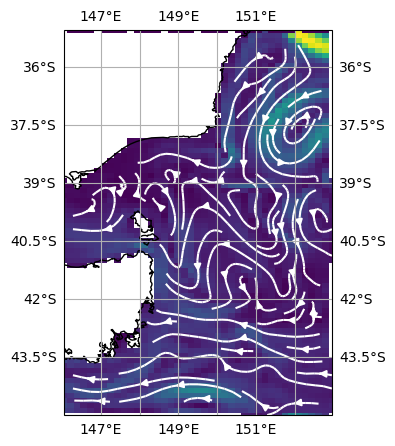

In [22]:
%%time
# x, y, u, v = regrid_for_streamplot(u=vel_dict['sthpac_u'], v=vel_dict['sthpac_v'],
#                                        res=2)
# plot streamplot for time = 100
u_snap = u.compute()
v_snap = v.compute()
# fig, ax = plt.subplots(figsize=(4,4), subplot_kw={'projection':ccrs.PlateCarree()})
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=(x.min()+x.max())/2))
ax.set_extent([x.min(), x.max(), y.min(), y.max()])
pc = ax.pcolormesh(x,y, speed, transform=ccrs.PlateCarree())
ax.streamplot(x, y, u_snap, v_snap, density=1, color='w', transform=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
ax.coastlines()

Okay, so now I have this capability - let's start combining this with the contour stuff to see whether the velocities are pointing in the right direction and s

## Heat Budget work

In [5]:
hb_ds = xr.open_zarr(zarr_head + 'eac-etas-HB_all-z25plus.zarr')
hb_ds

0.3.0


<xarray.Dataset>
Dimensions:                         (z_l: 12, time: 10075, yh: 393, xh: 210)
Coordinates:
  * time                            (time) object 1990-06-02 12:00:00 ... 201...
  * xh                              (xh) float64 -214.0 -213.9 ... -207.0 -207.0
  * yh                              (yh) float64 -44.99 -44.97 ... -35.04 -35.01
  * z_l                             (z_l) float64 0.2928 26.13 ... 257.9 277.3
Data variables:
    T_advection_xy                  (z_l, time, yh, xh) float32 dask.array<chunksize=(7, 49, 393, 210), meta=np.ndarray>
    Th_tendency_vert_remap          (z_l, time, yh, xh) float32 dask.array<chunksize=(7, 49, 393, 210), meta=np.ndarray>
    boundary_forcing_heat_tendency  (z_l, time, yh, xh) float32 dask.array<chunksize=(7, 49, 393, 210), meta=np.ndarray>
    opottempdiff                    (z_l, time, yh, xh) float32 dask.array<chunksize=(7, 49, 393, 210), meta=np.ndarray>
    opottemppmdiff                  (z_l, time, yh, xh) float32 dask.array<chunksize=(7, 49, 393, 210), meta=np.ndarray>
    opottemptend                    (z_l, time, yh, xh) float32 dask.array<chunksize=(7, 49, 393, 210), meta=np.ndarray>

### Conservation of vertically-extensive tracer content
Conservation of tracer concentration $\phi$ can be written:
$$
\rho \frac{D\phi}{Dt} = -\nabla\cdot\bf{J}_{\phi} + \rho S_{\phi}
$$
where $D/Dt$ is the material derivative, $\bf{J}_{\phi}$ is the diffusive (non-advective) tracer flux, and $S_{\phi}$ are sources/sinks. 

#### Sign Convention
The sign convention is such that the grid-cell time tendency is equal to the sum of all the other terms. As such, in equating the left and right sides of the tracer conservation equation, it is necessary to *take away* the along-layer and across-layer advective terms from the grid-cell time tendency. **For the Heat Budget:**

    dhdt - dynamics_h_tendency - vert_remap_h_tendency = boundary_forcing_h_tendency

    
#### Showing Budget Closure
Here we confirm that, given the terms in the table above, the left hand side (material derivative) and right hand side (diffusive fluxes, sources/sinks) of the tracer conservation equation are equal and thus sum to zero. We confirm this for (a) the full depth integral, (b) a single profile, and (c) integrated within each layer (full 3D closure). 

In [6]:
hb_terms = list(hb_ds.data_vars)
hb_terms

['T_advection_xy',
 'Th_tendency_vert_remap',
 'boundary_forcing_heat_tendency',
 'opottempdiff',
 'opottemppmdiff',
 'opottemptend']

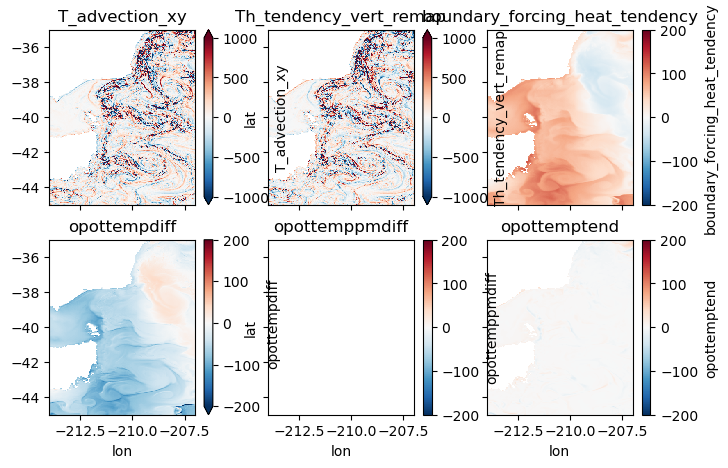

In [107]:
# let's plot all the terms for a single time to understand what they look like
fig, axs = plt.subplots(2, 3, figsize=(8,5), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
    if hb_terms[i] in ['T_advection_xy','Th_tendency_vert_remap']:
        hb_ds[hb_terms[i]].isel(z_l=0, time=100).plot(ax=ax, cmap='RdBu_r', vmin=-1000, vmax=1000)
    else:
        hb_ds[hb_terms[i]].isel(z_l=0, time=100).plot(ax=ax, cmap='RdBu_r', vmin=-200, vmax=200)
    ax.set_title(f'{hb_terms[i]}')
    if i in range(3,6):
        ax.set_xlabel('lon')
    else:
        ax.set_xlabel('')
    if i in [1,4]:
        ax.set_ylabel('lat'); 
    else:
        ax.set_ylabel('')
    
    

In [28]:
# add all vars except opottemptend
hb_ds_snap = hb_ds.isel(z_l=0, time=100)
hb_rhs = xr.Dataset()
hb_lhs = xr.Dataset()

hb_lhs['dTdt'] = xr.zeros_like(hb_ds_snap[hb_terms[0]])
hb_rhs['heat_sum'] = xr.zeros_like(hb_ds_snap[hb_terms[0]])

for term in hb_terms:
    if term == 'opottemptend':
        hb_lhs['dTdt'] = hb_ds_snap[term]
    elif term != 'opottemppmdiff':
        hb_rhs['heat_sum'] += hb_ds_snap[term]

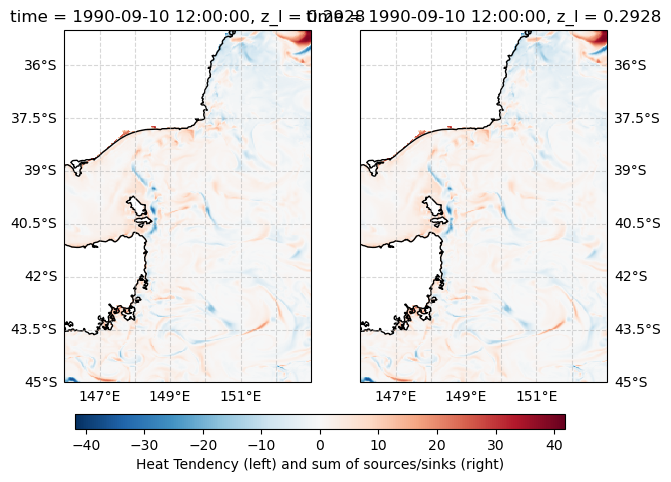

In [29]:
fig, axs = plt.subplots(1,2, figsize=(7,5), subplot_kw = {'projection':ccrs.PlateCarree()}, sharey=True)
hb_lhs['dTdt'].plot(ax=axs[0], transform=ccrs.PlateCarree(), add_colorbar=False)
p = hb_rhs['heat_sum'].plot(ax=axs[1], transform=ccrs.PlateCarree(), add_colorbar=False)
for i, ax in enumerate(axs.flatten()):
    gs = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
    gs.top_labels=False;
    if i == 0: 
        gs.right_labels=False
    if i == 1: 
        gs.left_labels=False
    ax.coastlines()
cb = fig.colorbar(p, cax=fig.add_axes([0.14, 0.05, 0.7, 0.03]), orientation='horizontal')
cb.set_label('Heat Tendency (left) and sum of sources/sinks (right)')

Okay, so what are some interesting plots I could quickly make for the meeting this afternoon? 
* Heat budget time-series within a bioregion?
* Hovmollers of HB Terms?
* Along Contour:
  - Average fluxes?
 
Let's go with the bioregion example - taking heat budget in the Freycinet bioregion;

#### Bioregion Heat budget

In [7]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon

In [8]:
# get bioregions
bioregs = gpd.read_file('/g/data/v45/jr5971/notebooks/data/bioregions-IMCRA/imcra4_meso.shp')
bioregs[-5:]

,MESO_NAME,MESO_NUM,MESO_ABBR,WATER_TYPE,AREA_KM2,geometry
57,Boags,45,BGS,Cold Temperate Waters,8076.564645,"POLYGON ((144.64587 -40.25713, 144.69162 -40.2..."
58,Freycinet,48,FRT,Cold Temperate Waters,7947.917514,"POLYGON ((148.38129 -40.70045, 148.38249 -40.6..."
59,Franklin,57,FRA,Cold Temperate Waters,10361.951871,"POLYGON ((144.68779 -40.74937, 144.68820 -40.7..."
60,Bruny,47,BRU,Cold Temperate Waters,7278.438914,"POLYGON ((147.53393 -42.77710, 147.53642 -42.7..."
61,Davey,46,DAV,Cold Temperate Waters,6783.884210,"POLYGON ((145.75940 -43.19016, 145.75959 -43.1..."


In [9]:
%%time
freyc_bioreg = bioregs[bioregs['MESO_NAME']=='Freycinet']
# create spatial average object
spav_eac = xesmf.SpatialAverager(hb_ds, freyc_bioreg.geometry, geom_dim_name='bioregion', ignore_holes=False)

spav_hb_ds = spav_eac(hb_ds, skipna=True)

CPU times: user 7.31 s, sys: 374 ms, total: 7.69 s
Wall time: 7.43 s


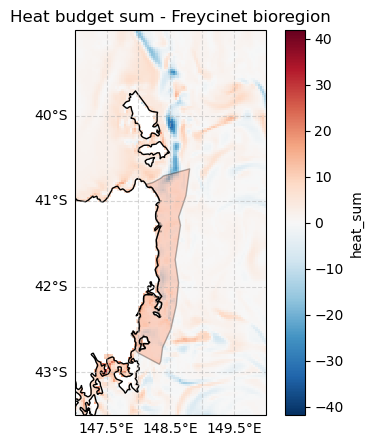

In [43]:
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection':ccrs.PlateCarree()})

hb_lhs['dTdt'].plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
p = hb_rhs['heat_sum'].plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=True)

freyc_bioreg.plot(ax=ax, edgecolor='k', linewidth=1, facecolor='coral', alpha=0.3)
gs = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
gs.top_labels=False;
gs.right_labels=False

ax.coastlines()
ax.set_title('Heat budget sum - Freycinet bioregion')
ax.set_extent([147, 150, -43.5, -39], crs=ccrs.PlateCarree())
# cb = fig.colorbar(p, cax=fig.add_axes([0.14, 0.05, 0.7, 0.03]), orientation='horizontal')
# cb.set_label('Heat Tendency (left) and sum of sources/sinks (right)')

In [10]:
hb_terms

['T_advection_xy',
 'Th_tendency_vert_remap',
 'boundary_forcing_heat_tendency',
 'opottempdiff',
 'opottemppmdiff',
 'opottemptend']

In [11]:
%%time
frey_advection_surface = spav_hb_ds['T_advection_xy'].isel(z_l=0).compute()

CPU times: user 4.65 s, sys: 394 ms, total: 5.04 s
Wall time: 22.2 s


In [12]:
%%time
frey_thickness_tendency_surface = spav_hb_ds['Th_tendency_vert_remap'].isel(z_l=0).compute()

CPU times: user 4.27 s, sys: 346 ms, total: 4.62 s
Wall time: 18.9 s


In [13]:
%%time
frey_boundary_forcing_tendency_surface = spav_hb_ds['boundary_forcing_heat_tendency'].isel(z_l=0).compute()

CPU times: user 4.75 s, sys: 398 ms, total: 5.15 s
Wall time: 20.4 s


In [14]:
%%time
frey_dTdt = spav_hb_ds['opottemptend'].isel(z_l=0).compute()

CPU times: user 4.32 s, sys: 357 ms, total: 4.68 s
Wall time: 19.3 s


In [15]:
%%time
frey_opottempdiff = spav_hb_ds['opottempdiff'].isel(z_l=0).compute()

CPU times: user 5.02 s, sys: 416 ms, total: 5.43 s
Wall time: 19.9 s


In [30]:
frey_neut_diff = spav_hb_ds['opottemppmdiff'].isel(z_l=0).compute()

okay, so let's now look at a very short time period to see whether all these terms balance?

In [19]:
hb_terms = ['T_advection_xy', 'Th_tendency_vert_remap', 'boundary_forcing_heat_tendency',
            'opottemptend', 'opottempdiff']

In [21]:
frey_advection_surface.name

'T_advection_xy'

Text(0.5, 1.0, 'HB Terms averaged over Freycinet bioregion')

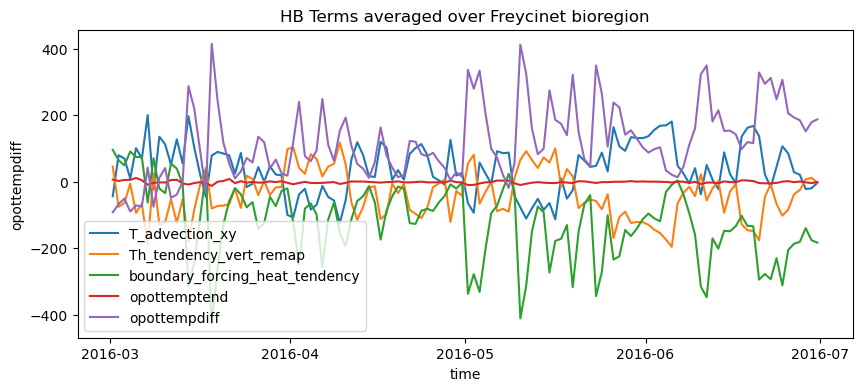

In [33]:
plt.figure(figsize=(10,4))
start = '2016-03'
end = '2016-06'
da_ls = [frey_advection_surface, frey_thickness_tendency_surface, frey_boundary_forcing_tendency_surface, 
         frey_dTdt, frey_opottempdiff]
for i, da in enumerate(da_ls):
    da.sel(time=slice(start, end)).plot(label=da.name)

plt.legend()
plt.title('HB Terms averaged over Freycinet bioregion')


Does taking the sum of all these equal the dTdt?

Text(0.5, 1.0, 'Heat Budget Closure - RHS = LHS')

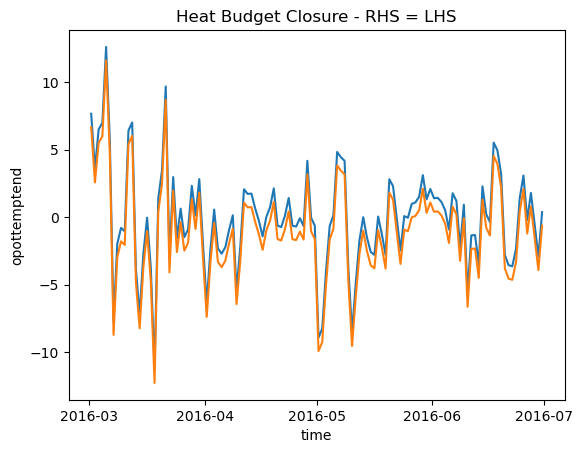

In [44]:
rhs_sum = frey_advection_surface + frey_boundary_forcing_tendency_surface + frey_opottempdiff + frey_thickness_tendency_surface +1
rhs_sum.sel(time=slice(start, end)).plot()
frey_dTdt.sel(time=slice(start,end)).plot()
plt.title('Heat Budget Closure - RHS = LHS')

Okay so I need to understand what these terms truly represent if I'm going to 

# 3. Marine Heatwaves
## 3.1 Initial data retrieval and exploration

In [5]:
mhw_path = '/home/581/jr5971/jr5971/mhw-analysis/eac-003_easttas/'
mhw_tmpdir = mhw_path + 'tmp-res/'

In [6]:
mhw_00 = '/home/581/jr5971/jr5971/mhw-analysis/eac-003_easttas/tmp-res/detect_z0/mhw_z0m_000.nc'
xr.open_dataset(mhw_00)

0.3.0


<xarray.Dataset>
Dimensions:                         (lon: 210, lat: 12, events: 2772)
Coordinates:
  * lon                             (lon) float64 -214.0 -213.9 ... -207.0
  * lat                             (lat) float64 -44.99 -44.97 ... -44.73
  * events                          (events) float64 162.0 206.0 ... 9.976e+03
Data variables: (12/31)
    event                           (events, lon, lat) float64 ...
    index_start                     (events, lon, lat) float64 ...
    index_end                       (events, lon, lat) float64 ...
    time_start                      (events, lon, lat) datetime64[ns] ...
    time_end                        (events, lon, lat) datetime64[ns] ...
    time_peak                       (events, lon, lat) datetime64[ns] ...
    ...                              ...
    intensity_var_relThresh         (events, lon, lat) float64 ...
    intensity_var_abs               (events, lon, lat) float32 ...
    category                        (events, lon, lat) float64 ...
    duration                        (events, lon, lat) float64 ...
    rate_onset                      (events, lon, lat) float64 ...
    rate_decline                    (events, lon, lat) float64 ...
Attributes:
    source:           xmhw code: https://github.com/coecms/xmhw
    title:            Marine heatwave events identified applying the Hobday e...
    history:          2024-04-25: calculated using xmhw code https://github.c...
    xmhw_parameters:  MHW detected using: 5 days of minimum duration;\n      ...

In [7]:
# get mhw results for surface layer
depth = 0 #m
detect_layer_files = glob.glob(mhw_tmpdir + f'detect_z{depth}/mhw*.nc')
int_layer_files = glob.glob(mhw_tmpdir + f'detect_z{depth}/int*.nc')
detect_layer_files.sort()
int_layer_files.sort()
print(len(detect_layer_files))
print(len(int_layer_files))
# open dataset
mhw_0m = xr.open_mfdataset(detect_layer_files, combine='nested', concat_dim='lat')
int_0m = xr.open_mfdataset(int_layer_files, combine='nested', concat_dim='lat')

33
33


In [8]:
%%time
# calculate mhw temperature anomalies
mhw_0m_anom = int_0m['ts'] - int_0m['seas']
mhw_0m_anom = mhw_0m_anom[:100].compute()
mhw_0m_anom

CPU times: user 1.12 s, sys: 156 ms, total: 1.27 s
Wall time: 6.1 s


<xarray.DataArray (time: 100, lon: 210, lat: 393)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -214.0 -213.9 -213.9 -213.9 ... -207.1 -207.0 -207.0
  * time     (time) datetime64[ns] 1990-02-02T12:00:00 ... 1990-05-12T12:00:00
  * lat      (lat) float64 -44.99 -44.97 -44.94 -44.92 ... -35.06 -35.04 -35.01

In [11]:
mhw_0m_anom.to_netcdf('/scratch/v45/jr5971/widget_sample_data/mhw_anomaly.nc')

In [9]:
def plot_mhws(i):
    fig, ax = plt.subplots(figsize=(5,5))
    mhw_0m_anom.isel(time=i).plot(ax=ax, cmap=cmo.cm.balance, vmin=-3, vmax=3)

In [10]:
interact(plot_mhws, i=(0, len(mhw_0m_anom.time), 1))

interactive(children=(IntSlider(value=50, description='i'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_mhws(i)>

# 4. Contour work
### Extracting contour and smoothing

<function silent_list.index(value, start=0, stop=9223372036854775807, /)>

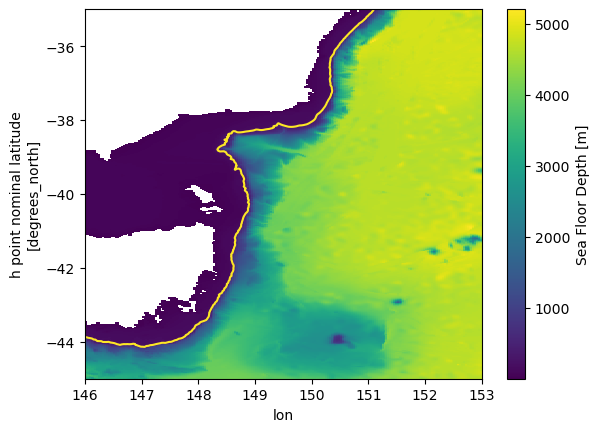

In [36]:
bath_etas.plot()
c300 = bath_etas.plot.contour(levels=[300])
c300.collections.index

In [37]:
shelfbreak_contour = c300.allsegs[0][0]
shelfbreak_contour.shape

(595, 2)

**Resample the contour array**

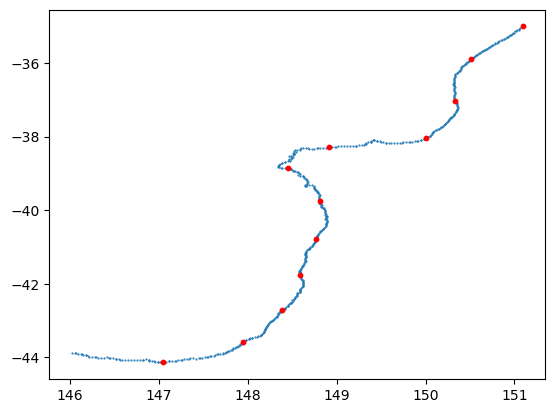

In [38]:
plt.scatter(shelfbreak_contour[:,0], shelfbreak_contour[:,1], s=0.3)
# downsample
shelfbreak_downsampled = shelfbreak_contour[::50]
plt.scatter(shelfbreak_downsampled[:,0], shelfbreak_downsampled[:,1], s=10, color='r')

**Smooth contour through interpolation of resampled contour points**

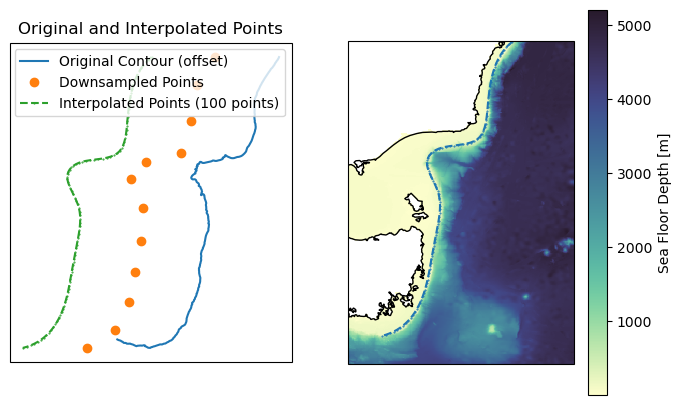

In [39]:
from scipy.interpolate import interp1d

# Step 1: Import necessary libraries
# (numpy, scipy, and matplotlib)

# Step 2: Define the coordinate points that form the contour line
latitudes = shelfbreak_downsampled[:,1]
longitudes = shelfbreak_downsampled[:,0]

# Step 3: Create an interpolator for each of the latitude and longitude coordinates
interp_lat = interp1d(np.arange(len(latitudes)), latitudes, kind='cubic')
interp_lon = interp1d(np.arange(len(longitudes)), longitudes, kind='cubic')

# Step 4: Define the new x values (index values) for the interpolation
new_x = np.linspace(0, len(latitudes) - 1, num=100)  # 100 points for smooth interpolation

# Step 5: Interpolate the coordinates at the new x values
new_latitudes = interp_lat(new_x)
new_longitudes = interp_lon(new_x)

# Step 6: Plot the original and interpolated points
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,5), subplot_kw = {'projection':ccrs.PlateCarree()})
ax1.plot(shelfbreak_contour[:,0]+4, shelfbreak_contour[:,1], label='Original Contour (offset)')
ax1.plot(longitudes+2, latitudes, 'o', label='Downsampled Points')
ax1.plot(new_longitudes, new_latitudes, 'o--', markersize=0.5, label='Interpolated Points (100 points)')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.legend()
ax1.set_title('Original and Interpolated Points')

bath_etas.plot(ax=ax2, cmap = cmo.cm.deep)
# bath_etas.plot.contour(ax=ax2, levels=[300])
ax2.plot(new_longitudes, new_latitudes, 'o--', markersize=0.5)
ax2.coastlines()

Cool so the smoothed contour - although doesn't go the whole way around the bottom of Tasmania, should be fine for what we're interested in. 

**Compute normal to contour line**

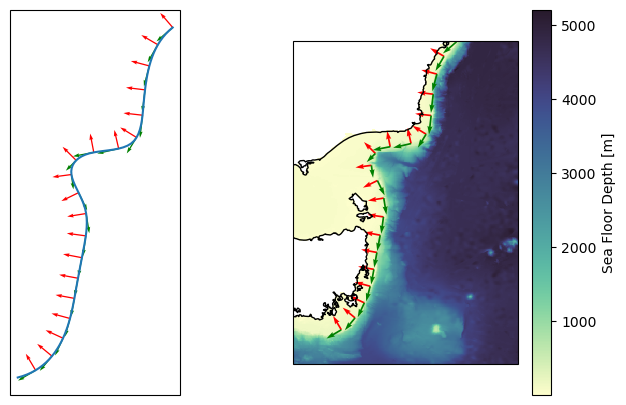

In [41]:
# compute tangent vector at each point along contour
d_lat = np.gradient(new_latitudes, new_x)
d_lon = np.gradient(new_longitudes, new_x)

# Calculate the normal vector by rotating the tangent vector 90 degrees
normals = np.zeros((len(new_x), 2))
normals[:,0] = d_lat
normals[:,1] = -d_lon

# Normalise normal vectors
norm_magnitude = np.sqrt(normals[:,0]**2 + normals[:,1]**2)
normals[:,0] /= norm_magnitude
normals[:,1] /= norm_magnitude

# Plot the contour line and the normal vectors
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,5), subplot_kw = {'projection':ccrs.PlateCarree()})
ax1.plot(new_longitudes, new_latitudes, label='Contour line')
bath_etas.plot(ax=ax2, cmap=cmo.cm.deep)
ax2.coastlines()
# Plot normal vectors at regular intervals along line
interval=5
for ax in [ax1, ax2]:
    for i in range(0, len(new_x), interval):
        ax.quiver(new_longitudes[i], new_latitudes[i], 
                   normals[i,0], normals[i,1], angles='xy', 
                   scale_units='xy', scale=2,
                   color='red', label='Normal Vector' if i==0 else None)
        ax.quiver(new_longitudes[i], new_latitudes[i], 
                   d_lon[i], d_lat[i], angles='xy', 
                   scale_units='xy', scale=2,
                   color='green', label='Tangent Vector' if i==0 else None)

    

In [42]:
tangent = np.zeros((100,2))
tangent[:,0] = d_lat
tangent[:,1] = d_lon

Okay so that looks to have fixed things - it was just an illusion that it wasn't normal due to the squashed lat length. Now then, what do I want to do with this? Start with the velocity? 

Let's load in the velocity files - then from there we can look at projecting those onto the normal contour vectors and look at cross-shelf velocities which will be pretty cool

In [23]:
uv = xr.open_zarr(zarr_head + 'eac-etas-uv-z25plus.zarr', consolidated=True)
u_2d_snap = uv['uo'].isel(time=0, z_l=0)
v_2d_snap = uv['vo'].isel(time=0, z_l=0)
vel_2d_snap = xr.merge([u_2d_snap, v_2d_snap])
vel_2d_snap

<xarray.Dataset>
Dimensions:  (xq: 210, yh: 393, xh: 210, yq: 392)
Coordinates:
    time     object 1990-02-02 12:00:00
  * xq       (xq) float64 -214.0 -214.0 -213.9 -213.9 ... -207.1 -207.1 -207.0
  * yh       (yh) float64 -44.99 -44.97 -44.94 -44.92 ... -35.06 -35.04 -35.01
    z_l      float64 0.2928
  * xh       (xh) float64 -214.0 -213.9 -213.9 -213.9 ... -207.1 -207.0 -207.0
  * yq       (yq) float64 -44.98 -44.95 -44.93 -44.91 ... -35.08 -35.05 -35.02
Data variables:
    uo       (yh, xq) float32 dask.array<chunksize=(393, 210), meta=np.ndarray>
    vo       (yq, xh) float32 dask.array<chunksize=(392, 210), meta=np.ndarray>

**Matrix rotation example**

In [24]:
len(new_latitudes)

100

In [66]:
# select u/v at one point along the contour line
u = u_2d_snap.sel(xq=new_longitudes[50], yh=new_latitudes[50], method='nearest')
v = v_2d_snap.sel(xh=new_longitudes[50], yq=new_latitudes[50], method='nearest')
print(u.values, v.values)

-0.029457698 -0.102213554


In [26]:
V = np.array([[u,0],
            [0,v]])
V

array([[-0.0294577 ,  0.        ],
       [ 0.        , -0.10221355]])

In [56]:
import math

In [40]:
normals[50]

array([-0.89862183, -0.43872406])

In [96]:
theta = np.arcsin(-0.9)

In [97]:
math.degrees(theta)

-64.15806723683288

In [58]:
math.degrees(np.arccos(0.4))

66.42182152179817

In [57]:
# degrees
theta_deg = math.degrees(theta)
theta_deg

-64.15806723683288

In [62]:
normals[50,1]

-0.4387240587797748

In [103]:
# Test on single point
theta = -np.arcsin(normals[50,0])
math.degrees(theta)

63.977500624568705

In [99]:
math.degrees(np.arccos(n2))

63.97750062456869

In [100]:
math.degrees(-np.arcsin(n1))

63.977500624568705

Okay, so I can get the angle. Then why doesn't the sum of the vectors add up? 

In [105]:
theta

1.1166180330954525

In [111]:
v.values

array(-0.10221355, dtype=float32)

In [110]:
u.values

array(-0.0294577, dtype=float32)

In [108]:
uprime = u*np.cos(theta) - v*np.sin(theta)
uprime.values

array(0.07892753, dtype=float32)

In [107]:
vprime = u*np.sin(theta) + v*np.cos(theta)
vprime.values

array(-0.07131488, dtype=float32)

In [115]:
np.sqrt(uprime**2 + vprime**2).values

array(0.10637371, dtype=float32)

In [116]:
np.sqrt(u**2 + v**2).values

array(0.10637371, dtype=float32)

In [128]:
new_longitudes.shape

(100,)

In [153]:
# get cross shore velocity
# get angles
# theta = -np.arcsin(normals[:,0])
# theta_check = np.arccos(normals[:,1])
# assert theta.all() == theta_check.all()
# # get velocities at points along contour;
# uv_contour = []
# for i,j in zip(new_longitudes, new_latitudes):
#     # find nearest point in u and v
#     u_point = u_2d_snap.sel(xq=i, yh=j, method='nearest')
#     v_point = v_2d_snap.sel(xh=i, yq=j, method='nearest')
#     uv_contour.append([u_point.values, v_point.values])
    
# calculate vprime (cross shore)
# uv_contour = np.array(uv_contour)
vprime = uv_contour[:,0]*np.sin(theta) + uv_contour[:,1]*np.cos(theta)
uprime = uv_contour[:,0]*np.cos(theta) - uv_contour[:,1]*np.sin(theta)

assert np.sqrt(vprime[0]**2 + uprime[0]**2) == np.sqrt(uv_contour[0,0]**2 + uv_contour[0,1]**2)
print('Magnitude of rotated vectors matches original u/v vectors')

Magnitude of rotated vectors matches original u/v vectors


Alrighty - now we have alongshore and cross shore velocity which is pretty cool. Let's make some quick comparisons to understand the difference between the two reference frames. 

In [167]:
vprime

array([-0.14146555, -0.06751695,  0.04719727,  0.264497  ,  0.56621238,
        0.78138305,  0.85678592,  0.72014691,  0.49689356,  0.11752873,
        0.08109634, -0.02902145, -0.25281284, -0.15774884, -0.09166542,
       -0.40068095, -0.31180198, -0.13692756,  0.02228792,  0.18242262,
        0.32407306,  0.40854277,  0.40724906,  0.3632128 ,  0.31613161,
        0.27117214,  0.22091649,  0.17252013,  0.11912002,  0.09559037,
        0.06399428,  0.06408702,  0.04792141,  0.03317803,  0.01477441,
        0.00914743, -0.01545135, -0.05784013, -0.08809283, -0.12736704,
       -0.15692476, -0.17593042, -0.15795638, -0.11897392, -0.06344311,
       -0.01385483,  0.06714578,  0.07099703, -0.00215994, -0.03523857,
       -0.07131488, -0.08163214, -0.07721205, -0.07157068, -0.05998222,
       -0.04922562, -0.01894792,  0.03152928,  0.09897364,  0.09228252,
        0.06578883,  0.03679539,  0.01782318,  0.01474961,  0.03400985,
        0.06269057,  0.04333557,  0.02239466,  0.01988858,  0.03

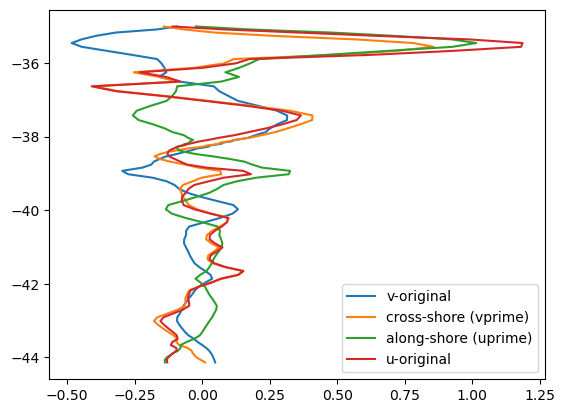

In [161]:
v_snap = uv_contour[:,1]
u_snap = uv_contour[:,0]
plt.plot(v_snap, new_latitudes, label='v-original')
plt.plot(vprime, new_latitudes, label='cross-shore (vprime)')
plt.plot(uprime, new_latitudes, label='along-shore (uprime)')
plt.plot(u_snap, new_latitudes, label='u-original')
plt.legend()


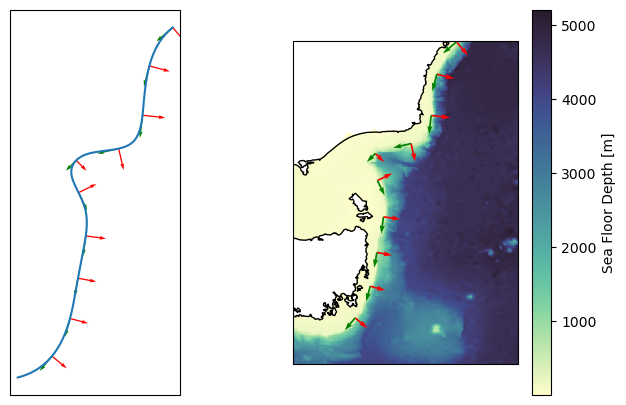

In [172]:
# # compute tangent vector at each point along contour
# d_lat = np.gradient(new_latitudes, new_x)
# d_lon = np.gradient(new_longitudes, new_x)

# # Calculate the normal vector by rotating the tangent vector 90 degrees
normals = np.zeros((len(new_x), 2))
normals[:,0] = -d_lat
normals[:,1] = d_lon

# # Normalise normal vectors
# norm_magnitude = np.sqrt(normals[:,0]**2 + normals[:,1]**2)
# normals[:,0] /= norm_magnitude
# normals[:,1] /= norm_magnitude

# Plot the contour line and the normal vectors
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,5), subplot_kw = {'projection':ccrs.PlateCarree()})
ax1.plot(new_longitudes, new_latitudes, label='Contour line')
bath_etas.plot(ax=ax2, cmap=cmo.cm.deep)
ax2.coastlines()
# Plot normal vectors at regular intervals along line
interval=10
for ax in [ax1, ax2]:
    for i in range(0, len(new_x), interval):
        ax.quiver(new_longitudes[i], new_latitudes[i], 
                   normals[i,0], normals[i,1], angles='xy', 
                   scale_units='xy', scale=2,
                   color='red', label='Normal Vector' if i==0 else None)
        ax.quiver(new_longitudes[i], new_latitudes[i], 
                   d_lon[i], d_lat[i], angles='xy', 
                   scale_units='xy', scale=2,
                   color='green', label='Tangent Vector' if i==0 else None)

    

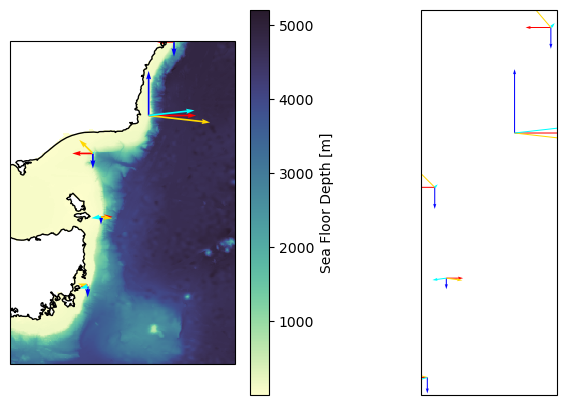

In [174]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,5), subplot_kw = {'projection':ccrs.PlateCarree()})
bath_etas.plot(ax=ax1, cmap=cmo.cm.deep)
ax1.coastlines()
# plot along/cross shore and original vectors too
interval = 20
for ax in [ax1, ax2]:
    for i in range(0, len(new_x), interval):
        ax.quiver(new_longitudes[i], new_latitudes[i], 
                  uv_contour[i,0], 0, angles='xy',
                  scale_units='xy', scale=.2, color='red', 
                  label='U' if i==0 else None)
        ax.quiver(new_longitudes[i], new_latitudes[i], 
                  0, uv_contour[i,1], angles='xy',
                  scale_units='xy', scale=0.2, color='blue', 
                  label='V' if i==0 else None)
        ax.quiver(new_longitudes[i], new_latitudes[i], 
                  normals[i,0]*vprime[i], normals[i,1]*vprime[i], angles='xy',
                  scale_units='xy', scale=0.2, color='gold', 
                  label='Cross-V' if i==0 else None)
        ax.quiver(new_longitudes[i], new_latitudes[i], 
                  tangent[i,0]*uprime[i], tangent[i,1]*uprime[i], angles='xy',
                  scale_units='xy', scale=0.2, color='aqua', 
                  label='Along-U' if i==0 else None)
        

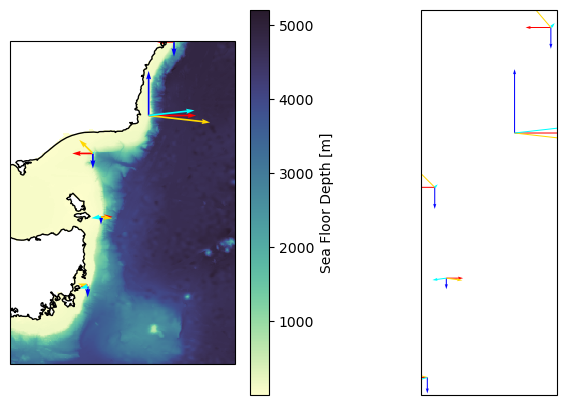

In [174]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,5), subplot_kw = {'projection':ccrs.PlateCarree()})
bath_etas.plot(ax=ax1, cmap=cmo.cm.deep)
ax1.coastlines()
# plot along/cross shore and original vectors too
interval = 20
for ax in [ax1, ax2]:
    for i in range(0, len(new_x), interval):
        ax.quiver(new_longitudes[i], new_latitudes[i], 
                  uv_contour[i,0], 0, angles='xy',
                  scale_units='xy', scale=.2, color='red', 
                  label='U' if i==0 else None)
        ax.quiver(new_longitudes[i], new_latitudes[i], 
                  0, uv_contour[i,1], angles='xy',
                  scale_units='xy', scale=0.2, color='blue', 
                  label='V' if i==0 else None)
        ax.quiver(new_longitudes[i], new_latitudes[i], 
                  normals[i,0]*vprime[i], normals[i,1]*vprime[i], angles='xy',
                  scale_units='xy', scale=0.2, color='gold', 
                  label='Cross-V' if i==0 else None)
        ax.quiver(new_longitudes[i], new_latitudes[i], 
                  tangent[i,0]*uprime[i], tangent[i,1]*uprime[i], angles='xy',
                  scale_units='xy', scale=0.2, color='aqua', 
                  label='Along-U' if i==0 else None)
        

In [183]:
uv_contour[25]

array([0.17385255, 0.23535298], dtype=float32)

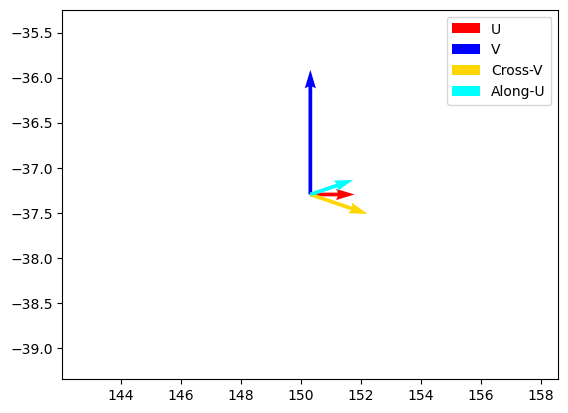

In [181]:
# plot along/cross shore and original vectors too
ax = plt.axes()
interval = 20
i = 20
ax.quiver(new_longitudes[i], new_latitudes[i], 
          uv_contour[i,0], 0, angles='xy',
          scale_units='xy', scale=.2, color='red', 
          label='U')
ax.quiver(new_longitudes[i], new_latitudes[i], 
          0, uv_contour[i,1], angles='xy',
          scale_units='xy', scale=0.2, color='blue', 
          label='V')
ax.quiver(new_longitudes[i], new_latitudes[i], 
          normals[i,0]*vprime[i], normals[i,1]*vprime[i], angles='xy',
          scale_units='xy', scale=0.2, color='gold', 
          label='Cross-V')
ax.quiver(new_longitudes[i], new_latitudes[i], 
          tangent[i,0]*uprime[i], tangent[i,1]*uprime[i], angles='xy',
          scale_units='xy', scale=0.2, color='aqua', 
          label='Along-U')
ax.legend()

In [171]:
normals

array([[-0.65074046,  0.75930024],
       [-0.67965114,  0.7335355 ],
       [-0.73464148,  0.67845553],
       [-0.78401769,  0.62073848],
       [-0.82716389,  0.56196076],
       [-0.86390067,  0.50366222],
       [-0.89443173,  0.44720452],
       [-0.91924604,  0.39368353],
       [-0.9390065 ,  0.34389939],
       [-0.95444958,  0.29837226],
       [-0.96630869,  0.25738593],
       [-0.97526419,  0.22104242],
       [-0.98191623,  0.18931591],
       [-0.98677444,  0.16209935],
       [-0.99025845,  0.13924152],
       [-0.99270428,  0.12057454],
       [-0.99437323,  0.10593334],
       [-0.99546117,  0.09516861],
       [-0.9960142 ,  0.08919475],
       [-0.99565659,  0.09310188],
       [-0.99366723,  0.11236296],
       [-0.98879312,  0.1492922 ],
       [-0.9785028 ,  0.20623354],
       [-0.95815618,  0.28624594],
       [-0.92000968,  0.39189562],
       [-0.85279762,  0.52224154],
       [-0.74439932,  0.66773472],
       [-0.59481061,  0.80386587],
       [-0.43880216,

In [121]:
np.dot(n1, u)  + (np.dot(n2, v))

-0.01837221503197042

In [98]:
math.degrees(np.cos(normals[50,1]))

51.86954835480656

In [79]:
t1 = tangent[50, 0]
t2 = tangent[50,1]
print(t1, t2)

-0.9224807077382593 0.4503724091780441


In [78]:
n1 = normals[50,0]
n2 = normals[50,1]*-1
print(n1, n2)

-0.8986218338365705 0.4387240587797748


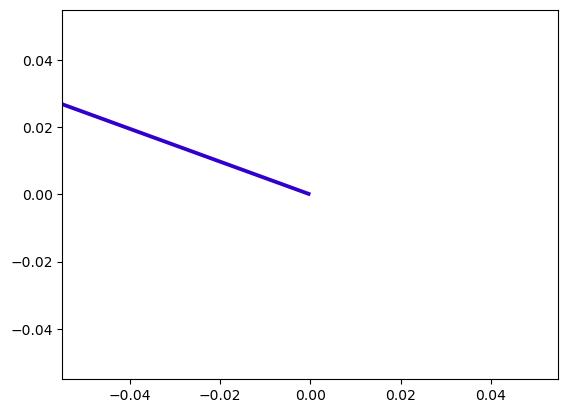

In [82]:
plt.quiver(0, 0, t1, t2, angles='xy', scale_units='xy', scale=1, color='blue', label='Original u (East)')
plt.quiver(0, 0, n1, n2, angles='xy', scale_units='xy', scale=1, color='red', alpha=0.2, label='Original v (North)')
# plt.quiver(0, 0, u_rotated[0], u_rotated[1], angles='xy', scale_units='xy', scale=1, color='cyan', label='Rotated u')
# plt.quiver(0, 0, v_rotated[0], v_rotated[1], angles='xy', scale_units='xy', scale=1, color='orange', label='Rotated v')

In [75]:
assert theta == np.arccos(normals[50,1])

AssertionError: 

In [69]:
uprime = u*np.cos(theta) + v*np.sin(theta)
uprime.values

array(-0.10477513, dtype=float32)

In [68]:
vprime = u*np.sin(theta) + v*np.cos(theta)
vprime.values

array(-0.07131488, dtype=float32)

In [72]:
np.sqrt(uprime**2 + vprime**2).values

array(0.12674242, dtype=float32)

In [73]:
np.sqrt(u**2 + v**2).values

array(0.10637371, dtype=float32)

In [70]:
assert np.sqrt(uprime**2 + vprime**2) == np.sqrt(u**2 + v**2)

AssertionError: 

In [70]:
cross_shore_vel = normals[50].dot(V)
cross_shore_vel

array([-0.02717416, -0.04603416])

In [72]:
rotation_matrix

array([[ 0.93969262, -0.34202014],
       [ 0.34202014,  0.93969262]])

In [74]:
normals.shape

(100, 2)

In [45]:
rotation_matrix

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

In [47]:
1/np.sqrt(2)

0.7071067811865475

In [48]:
v_rotated

array([-0.70710678,  0.70710678])

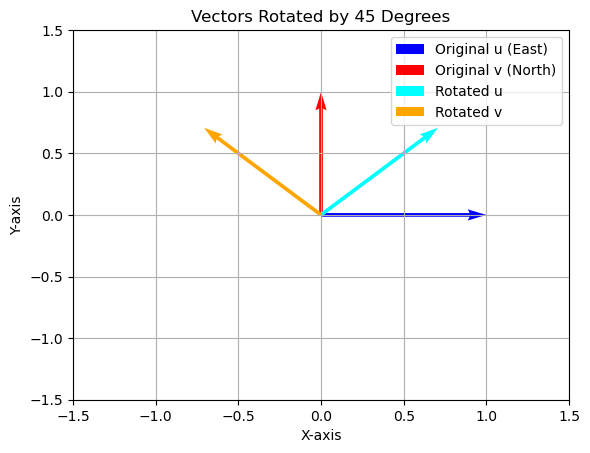

In [44]:
# define u and v vectors 
u = np.array([1,0])
v = np.array([0,1])

# define rotation angle
rotation_angle_degrees = 45
# to radians
rotation_angle_radians = np.radians(rotation_angle_degrees)

# create rotation matrix
rotation_matrix = np.array([
    [np.cos(rotation_angle_radians), -np.sin(rotation_angle_radians)],
    [np.sin(rotation_angle_radians), np.cos(rotation_angle_radians)]
])

# apply rotation matrix to u and v vectors
u_rotated = rotation_matrix.dot(u)
v_rotated = rotation_matrix.dot(v)

# plot original and rotated vectors
# Plot the original and rotated vectors
plt.figure()
plt.quiver(0, 0, u[0], u[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Original u (East)')
plt.quiver(0, 0, v[0], v[1], angles='xy', scale_units='xy', scale=1, color='red', label='Original v (North)')
plt.quiver(0, 0, u_rotated[0], u_rotated[1], angles='xy', scale_units='xy', scale=1, color='cyan', label='Rotated u')
plt.quiver(0, 0, v_rotated[0], v_rotated[1], angles='xy', scale_units='xy', scale=1, color='orange', label='Rotated v')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title(f'Vectors Rotated by {rotation_angle_degrees} Degrees')
plt.legend()
plt.grid(True)
plt.show()


                        